# Calculate Summary Stats from Bike to Surf Month
- I have a good record of what board I used and when so the dataset can be examined for relationships that we don't always have the data to find
- For example, I want to know if there's a relationship between board volume and GPS fixes
- My hypothesis is that a bigger, more buoyant board will keep the fin closer to the sky and therefore retrieve more GPS fixes per time in water

In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import numpy as np
from scipy import stats
import os
import datetime
import pytz
import re
import time

from os import listdir
from os.path import isfile, join

import requests

import folium
from folium.features import CustomIcon
import cmocean
import gpxpy

from scraping_utils import get_resampled_dfs_from_ride_id

%matplotlib notebook

In [2]:
MSW_US = pd.read_csv('../../MSW-US.csv')
MSW_US.head()

,Index,Name,Lat,Lon,URL:,Net Cam?,Country,Biked?,Session_ID,board
0,829,'37th Street',29.2803,-94.8027,/37th-Street-Surf-Report/3954/,False,us,NaN,NaN,NaN
1,830,61st Street,29.2658,-94.8251,/61st-Street-Surf-Report/3944/,False,us,NaN,NaN,NaN
2,831,880,27.9980,-82.8300,/880-Surf-Report/4619/,False,us,NaN,NaN,NaN
3,832,Alabama Point,30.2714,-87.5610,/Alabama-Point-Surf-Report/956/,False,us,NaN,NaN,NaN
4,833,Bob Hall Pier,27.5900,-97.2000,/Bob-Hall-Pier-Surf-Report/361/,False,us,NaN,NaN,NaN


### Manually enter SD County lat/lon bounds

In [3]:
lr_lat = 32.528556 
lr_lon = -117.055211
ul_lat = 33.215604
ul_lon = -117.407020

### Filter DataFrame
- Filter on lat/lon for SD's bounds
- Resort for readability

In [4]:
north_lat = MSW_US.Lat < ul_lat
south_lat = MSW_US.Lat > lr_lat
east_lon = MSW_US.Lon < lr_lon
west_lon = MSW_US.Lon > ul_lon

MSW_SanDiego = MSW_US[north_lat & south_lat & east_lon & west_lon]
MSW_SanDiego.sort_values(by = 'Lat', inplace = True, ascending = False)
MSW_SanDiego.reset_index(inplace = True, drop = True)
MSW_SanDiego

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


,Index,Name,Lat,Lon,URL:,Net Cam?,Country,Biked?,Session_ID,board
0,1029,Oceanside,33.192200,-117.386000,/Oceanside-Surf-Report/664/,True,us,yes,14235.0,almond-5-8
1,99997,Terra Mar,33.129180,-117.337813,/NANANA/NA,False,us,yes,14636.0,fatalbert-6-8
2,1038,Ponto,33.093853,-117.316894,/Ponto-Surf-Report/1149/,False,us,yes,14234.0,almond-5-8
3,979,Beacons,33.064600,-117.306400,/Beacons-Surf-Report/4562/,False,us,yes,14314.0,tjpro-9-0
4,1023,Moonlight/D Street,33.044732,-117.298681,/Moonlight-Surf-Report/4563/,False,us,yes,14684.0,fatalbert-6-8
5,99999,Boneyards,33.036440,-117.297251,/NANANA/NA,False,us,yes,14123.0,longfish-7-6
6,99994,Pipes,33.026368,-117.288943,/NANANA/NA,False,us,yes,14097.0,almond-5-8
7,987,Cardiff Reef,33.014800,-117.284500,/Cardiff-Reef-Surf-Report/4663/,True,us,yes,14386.0,fish-5-10
8,100001,Seaside Reef,33.001015,-117.279670,/NANANA/NA,False,us,yes,14277.0,tjpro-9-0
9,100000,Tabletops,32.997799,-117.279684,/NANANA/NA,False,us,yes,14139.0,longfish-7-6


### Get into Smartfin data
- Get ride_ids from master datasheet
- Append info into master dataframe
- Plot

In [5]:
ride_ids = MSW_SanDiego.Session_ID[~np.isnan(MSW_SanDiego.Session_ID)]
ride_ids = (ride_ids.astype(int)).astype(str)

In [6]:
#%% Build lists and dataframes from fins and/or rides
        
appended_ocean_list = [] # list of DataFrames from original CSVs
appended_motion_list = []
appended_multiIndex = [] # fin_id & ride_id used to identify each DataFrame

# Look for the following text in the HTML contents in fcn below
str_id_ride = 'rideId = \'' # backslash allows us to look for single quote
str_id_date = 'var date = \'' # backslash allows us to look for single quote

#%% Ride ID scraper
# Input ride ID, get ocean and motion CSVs
# Base URL to which we'll append given ride IDs
ride_url_base = 'https://surf.smartfin.org/ride/'

# Look for the following text in the HTML contents in fcn below
str_id_csv = 'img id="temperatureChart" class="chart" src="' # OMG I can't believe this is how we're doing this. 

def get_csv_from_ride_id(rid):
    # Build URL for each individual ride
    ride_url = ride_url_base+str(rid)
    print(ride_url)
    
    # Get contents of ride_url
    html_contents = requests.get(ride_url).text
    
    # Find CSV identifier 
    loc_csv_id = html_contents.find(str_id_csv)
    
    # Different based on whether user logged in with FB or Google
    offset_googleOAuth = [46, 114]
    offset_facebkOAuth = [46, 112]
    if html_contents[loc_csv_id+59] == 'f': # Facebook login
        off0 = offset_facebkOAuth[0]
        off1 = offset_facebkOAuth[1]
    else: # Google login
        off0 = offset_googleOAuth[0]
        off1 = offset_googleOAuth[1]
        
    csv_id_longstr = html_contents[loc_csv_id+off0:loc_csv_id+off1]
    
#    print(csv_id_longstr)
    
    # Stitch together full URL for CSV
    if ("media" in csv_id_longstr) & ("Calibration" not in html_contents): # other junk URLs can exist and break everything
        
        ocean_csv_url = 'https://surf.smartfin.org/'+csv_id_longstr+'Ocean.CSV'
        motion_csv_url = 'https://surf.smartfin.org/'+csv_id_longstr+'Motion.CSV'
        
        print(ocean_csv_url)
        # Go to ocean_csv_url and grab contents (theoretically, a CSV)
        ocean_df_small = pd.read_csv(ocean_csv_url, parse_dates = [0])
        elapsed_timedelta = (ocean_df_small['UTC']-ocean_df_small['UTC'][0])
        ocean_df_small['elapsed'] = elapsed_timedelta/np.timedelta64(1, 's')
        
        motion_df_small = pd.read_csv(motion_csv_url, parse_dates = [0])
        
        # Reindex on timestamp if there are at least a few rows
        if len(ocean_df_small) > 1:
            ocean_df_small.set_index('UTC', drop = True, append = False, inplace = True)
            motion_df_small.set_index('UTC', drop = True, append = False, inplace = True)
            
            sample_interval = '6s'
            ocean_df_small_resample = ocean_df_small.resample(sample_interval).mean()
            motion_df_small_resample = motion_df_small.resample(sample_interval).mean()
            
            # No need to save many extra rows with no fix
            motion_df_small = motion_df_small[~np.isnan(motion_df_small.Latitude)]
            
            return ocean_df_small_resample, motion_df_small_resample

    else:
        ocean_df_small_resample = pd.DataFrame() # empty DF just so something is returned
        motion_df_small_resample = pd.DataFrame() 
        return ocean_df_small_resample, motion_df_small_resample
    
# Loop over ride_ids and find CSVs
for rid in ride_ids:
    try:
        # get given ride's CSV from its ride ID using function in utils
        new_ocean_df, new_motion_df = get_csv_from_ride_id(rid) 
        if not new_ocean_df.empty: # Calibration rides, for example
            # Append only if DF isn't empty. There may be a better way to control empty DFs which are created above
            appended_multiIndex.append(str(rid)) # build list to be multiIndex of future DataFrame
            appended_ocean_list.append(new_ocean_df)
            appended_motion_list.append(new_motion_df)
            print("Ride ", rid, "so far so good")
    except Exception as e: print(e)
    


https://surf.smartfin.org/ride/14235
https://surf.smartfin.org/media/201806/google_101440910315486450418_000666D321BE_180610182048_Ocean.CSV
Ride  14235 so far so good
https://surf.smartfin.org/ride/14636
https://surf.smartfin.org/media/201806/google_101440910315486450418_000666D321BE_180624160430_Ocean.CSV
Ride  14636 so far so good
https://surf.smartfin.org/ride/14234
https://surf.smartfin.org/media/201806/google_101440910315486450418_000666D321BE_180609185942_Ocean.CSV
Ride  14234 so far so good
https://surf.smartfin.org/ride/14314
https://surf.smartfin.org/media/201806/google_101440910315486450418_000666DD992E_180617163831_Ocean.CSV
Ride  14314 so far so good
https://surf.smartfin.org/ride/14684
https://surf.smartfin.org/media/201806/google_101440910315486450418_000666D321BE_180630154456_Ocean.CSV
Ride  14684 so far so good
https://surf.smartfin.org/ride/14123
https://surf.smartfin.org/media/201806/google_101440910315486450418_000666DD992E_180602164715_Ocean.CSV
Ride  14123 so far 

In [7]:
df_keys = tuple(appended_multiIndex) # keys gotta be a tuple, whatever that means
ocean_df = pd.concat(appended_ocean_list, keys = df_keys, names=['ride_id'])
motion_df = pd.concat(appended_motion_list, keys = df_keys, names = ['ride_id'])

# Just in case it's helpful to have descriptive column headers...
# ocean_df.columns.values[1] = 'V_temp_int (ADC counts)'
# ocean_df.columns.values[2] = 'Temp (int) (oC)' # this column is just copied from temp_ext
# ocean_df.columns.values[4] = 'V_temp_ext (ADC counts)'
# ocean_df.columns.values[5] = 'Temp (C)' 

# Merge to get lat/lon in temp DF
df_ocean_motion = pd.merge(ocean_df, motion_df, left_index = True, right_index = True)

pacific = pytz.timezone('US/Pacific')
daytimes = df_ocean_motion.index.get_level_values(-1)
daytimes = daytimes.tz_localize(pytz.utc).tz_convert(pacific)

df_ocean_motion.loc[:, 'Sample Time'] = daytimes
df_ocean_motion.reset_index(inplace = True)
df_ocean_motion.set_index('Sample Time', inplace = True)

df_ocean_motion.head()

,ride_id,UTC,Time_x,Temperature 1,Calibrated Temperature 1,Temperature 1 Stable,Temperature 2,Calibrated Temperature 2,Temperature 2 Stable,salinity,...,IMU A2,IMU A3,IMU G1,IMU G2,IMU G3,IMU M1,IMU M2,IMU M3,Latitude,Longitude
Sample Time,,,,,,,,,,,,,,,,,,,,,
2018-06-01 08:26:06-07:00,14097,2018-06-01 15:26:06,954610521.0,342.0,21.375,0.0,4886.0,19.240,0.0,NaN,...,93.666667,448.375000,-11.250000,-25.583333,2.250000,191.041667,111.625,168.375000,NaN,NaN
2018-06-01 08:26:12-07:00,14097,2018-06-01 15:26:12,954616541.0,342.0,21.375,0.0,4852.0,19.106,0.0,NaN,...,99.833333,458.375000,15.250000,-17.208333,-26.541667,199.541667,84.375,177.291667,NaN,NaN
2018-06-01 08:26:18-07:00,14097,2018-06-01 15:26:18,954622561.0,342.0,21.375,0.0,4822.0,18.989,0.0,NaN,...,87.541667,469.291667,-34.750000,9.666667,63.416667,194.125000,107.625,167.041667,NaN,NaN
2018-06-01 08:26:24-07:00,14097,2018-06-01 15:26:24,954628582.0,342.0,21.375,0.0,4797.0,18.891,0.0,NaN,...,62.416667,475.000000,-9.500000,-31.500000,1.625000,167.125000,142.375,158.708333,NaN,NaN
2018-06-01 08:26:30-07:00,14097,2018-06-01 15:26:30,954634602.0,342.0,21.375,0.0,4780.0,18.824,0.0,NaN,...,69.208333,437.291667,2.208333,16.000000,62.958333,176.791667,112.875,164.958333,NaN,NaN


### Filter dataframe based on temp

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in less
  if __name__ == '__main__':


,ride_id,UTC,Time_x,Temperature 1,Calibrated Temperature 1,Temperature 1 Stable,Temperature 2,Calibrated Temperature 2,Temperature 2 Stable,salinity,...,IMU A2,IMU A3,IMU G1,IMU G2,IMU G3,IMU M1,IMU M2,IMU M3,Latitude,Longitude
Sample Time,,,,,,,,,,,,,,,,,,,,,
2018-06-01 08:28:18-07:00,14097.0,2018-06-01 15:28:18,954736941.0,295.0,18.438,0.0,4573.0,18.012,0.0,NaN,...,485.708333,41.208333,4.166667,-1.000000,7.125000,177.375000,-26.625000,493.208333,NaN,NaN
2018-06-01 08:28:24-07:00,14097.0,2018-06-01 15:28:24,954742961.0,294.0,18.375,0.0,4561.0,17.965,0.0,NaN,...,503.375000,1.458333,-47.208333,12.291667,36.750000,149.666667,-19.250000,490.416667,NaN,NaN
2018-06-01 08:28:30-07:00,14097.0,2018-06-01 15:28:30,954748981.0,294.0,18.375,0.0,4567.0,17.989,0.0,NaN,...,519.125000,0.666667,-24.958333,-45.083333,11.208333,179.750000,-16.583333,518.083333,NaN,NaN
2018-06-01 08:28:36-07:00,14097.0,2018-06-01 15:28:36,954755000.0,293.0,18.312,0.0,4568.0,17.993,0.0,NaN,...,498.458333,51.958333,13.583333,-10.875000,17.583333,172.250000,-23.333333,493.833333,NaN,NaN
2018-06-01 08:28:42-07:00,14097.0,2018-06-01 15:28:42,954761021.0,293.0,18.312,0.0,4572.0,18.008,0.0,NaN,...,488.541667,64.666667,-37.208333,-1.958333,-7.375000,172.666667,-29.166667,484.250000,NaN,NaN


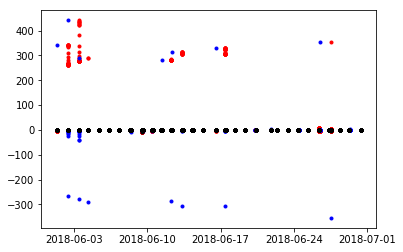

In [8]:
# Grab int and ext for better readability
temp_int = df_ocean_motion.loc[:, 'Calibrated Temperature 1']
temp_ext = df_ocean_motion.loc[:, 'Calibrated Temperature 2']
temp_diff_pre = temp_ext-temp_int
diff_temp_diff_pre = np.diff(temp_diff_pre)
diff_temp_diff_pre = np.append(diff_temp_diff_pre, diff_temp_diff_pre[-1]) # derivative of the difference
A2 = df_ocean_motion.loc[:, 'IMU A2'] # z-dimension (into board)
# Get rid of data outside of this temp difference range
simple_filter = (diff_temp_diff_pre > -0.09) & \
                (diff_temp_diff_pre < 0.09) & \
                (temp_ext > 5) & \
                (temp_ext <40) & \
                (A2 < 600) & \
                (A2 > 400)
full_df_filt = pd.DataFrame(df_ocean_motion[simple_filter])

# Grab int and ext again after filter
temp_int = full_df_filt.loc[:, 'Calibrated Temperature 1']
temp_ext = full_df_filt.loc[:, 'Calibrated Temperature 2']
temp_diff_post = temp_ext-temp_int

# Plot pre and post temp-diff-filtered data
plt.figure()
plt.plot(temp_diff_pre.index.get_level_values(-1), temp_diff_pre.values, 'r.')
plt.plot(temp_diff_pre.index.get_level_values(-1), diff_temp_diff_pre, 'b.')
plt.plot(temp_diff_post.index.get_level_values(-1), temp_diff_post.values, 'k.')

full_df_filt.ride_id = full_df_filt.ride_id.astype(float)
full_df_filt.head()

In [9]:
df_with_board = full_df_filt.merge(MSW_SanDiego, how = 'outer', left_on='ride_id', right_on='Session_ID')
df_with_board.head()

,ride_id,UTC,Time_x,Temperature 1,Calibrated Temperature 1,Temperature 1 Stable,Temperature 2,Calibrated Temperature 2,Temperature 2 Stable,salinity,...,Index,Name,Lat,Lon,URL:,Net Cam?,Country,Biked?,Session_ID,board
0,14097.0,2018-06-01 15:28:18,954736941.0,295.0,18.438,0.0,4573.0,18.012,0.0,NaN,...,99994,Pipes,33.026368,-117.288943,/NANANA/NA,False,us,yes,14097.0,almond-5-8
1,14097.0,2018-06-01 15:28:24,954742961.0,294.0,18.375,0.0,4561.0,17.965,0.0,NaN,...,99994,Pipes,33.026368,-117.288943,/NANANA/NA,False,us,yes,14097.0,almond-5-8
2,14097.0,2018-06-01 15:28:30,954748981.0,294.0,18.375,0.0,4567.0,17.989,0.0,NaN,...,99994,Pipes,33.026368,-117.288943,/NANANA/NA,False,us,yes,14097.0,almond-5-8
3,14097.0,2018-06-01 15:28:36,954755000.0,293.0,18.312,0.0,4568.0,17.993,0.0,NaN,...,99994,Pipes,33.026368,-117.288943,/NANANA/NA,False,us,yes,14097.0,almond-5-8
4,14097.0,2018-06-01 15:28:42,954761021.0,293.0,18.312,0.0,4572.0,18.008,0.0,NaN,...,99994,Pipes,33.026368,-117.288943,/NANANA/NA,False,us,yes,14097.0,almond-5-8


In [10]:
def board_vol_by_name(row):
    if row['board'] == 'almond-5-8':
        return 32.4
    if row['board'] == 'fatalbert-6-8':
        return 32.4
    if row['board'] == 'tj-pro':
        return 32.4
    if row['board'] == 'almond-5-8':
        return 32.4

In [11]:
df_with_board.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
ride_id,14282.0,1.434050e+04,1.872070e+02,1.409700e+04,1.417500e+04,1.429600e+04,1.438600e+04,1.468400e+04
Time_x,14282.0,2.061408e+09,1.181659e+09,1.024400e+08,9.553645e+08,1.785652e+09,3.192555e+09,3.860626e+09
Temperature 1,14282.0,3.224518e+02,1.597089e+01,2.770000e+02,3.090000e+02,3.240000e+02,3.340000e+02,5.340000e+02
Calibrated Temperature 1,14282.0,2.015326e+01,9.981721e-01,1.731200e+01,1.931200e+01,2.025000e+01,2.087500e+01,3.337500e+01
Temperature 1 Stable,14282.0,4.743033e-01,4.993567e-01,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00
Temperature 2,14282.0,5.035858e+03,2.508811e+02,4.486000e+03,4.827000e+03,5.092000e+03,5.242000e+03,6.702000e+03
Calibrated Temperature 2,14282.0,1.975177e+01,9.829010e-01,1.752300e+01,1.896100e+01,2.000800e+01,2.049600e+01,2.636100e+01
Temperature 2 Stable,14282.0,4.558885e-01,4.980678e-01,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00
salinity,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Calibrated Salinity,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
df_with_board.loc[:, 'unique_lat'] = ~df_with_board.loc[:, 'Longitude'].duplicated()
df_with_board.head()

,ride_id,UTC,Time_x,Temperature 1,Calibrated Temperature 1,Temperature 1 Stable,Temperature 2,Calibrated Temperature 2,Temperature 2 Stable,salinity,...,Name,Lat,Lon,URL:,Net Cam?,Country,Biked?,Session_ID,board,unique_lat
0,14097.0,2018-06-01 15:28:18,954736941.0,295.0,18.438,0.0,4573.0,18.012,0.0,NaN,...,Pipes,33.026368,-117.288943,/NANANA/NA,False,us,yes,14097.0,almond-5-8,True
1,14097.0,2018-06-01 15:28:24,954742961.0,294.0,18.375,0.0,4561.0,17.965,0.0,NaN,...,Pipes,33.026368,-117.288943,/NANANA/NA,False,us,yes,14097.0,almond-5-8,False
2,14097.0,2018-06-01 15:28:30,954748981.0,294.0,18.375,0.0,4567.0,17.989,0.0,NaN,...,Pipes,33.026368,-117.288943,/NANANA/NA,False,us,yes,14097.0,almond-5-8,False
3,14097.0,2018-06-01 15:28:36,954755000.0,293.0,18.312,0.0,4568.0,17.993,0.0,NaN,...,Pipes,33.026368,-117.288943,/NANANA/NA,False,us,yes,14097.0,almond-5-8,False
4,14097.0,2018-06-01 15:28:42,954761021.0,293.0,18.312,0.0,4572.0,18.008,0.0,NaN,...,Pipes,33.026368,-117.288943,/NANANA/NA,False,us,yes,14097.0,almond-5-8,False


In [13]:
685/14282

0.04796247024226299

In [14]:
import sys
sys.version
sys.version_info

sys.version_info(major=3, minor=6, micro=5, releaselevel='final', serial=0)

In [15]:
groupby_board = df_with_board.groupby('board')

In [16]:
board_data_uniq = groupby_board.sum()
board_data_uniq

,ride_id,Time_x,Temperature 1,Calibrated Temperature 1,Temperature 1 Stable,Temperature 2,Calibrated Temperature 2,Temperature 2 Stable,salinity,Calibrated Salinity,...,IMU M2,IMU M3,Latitude,Longitude,Index,Lat,Lon,Net Cam?,Session_ID,unique_lat
board,,,,,,,,,,,,,,,,,,,,,
almond-5-8,20132102.0,2.252561e+12,460065.0,28753.951,627.0,7235338.0,28485.421,526.0,0.0,0.0,...,-44034.678162,5.623201e+05,3.772060e+09,-1.335474e+10,28975124,46935.220541,-166272.423080,610.0,20132102.0,5.0
fatalbert-6-8,36083460.0,7.884541e+12,815311.0,50956.746,1252.0,12839285.0,50544.636,1230.0,0.0,0.0,...,-70537.577549,8.814952e+05,5.933043e+09,-2.108929e+10,199791188,81429.867458,-289825.223338,0.0,36083460.0,112.0
fish-5-10,49774912.0,7.657012e+12,1082429.0,67651.827,1413.0,17029383.0,67056.534,1234.0,0.0,0.0,...,-68218.051539,1.477064e+06,9.425591e+09,-3.363094e+10,74244396,114660.725639,-408901.272768,1051.0,49774912.0,40.0
longfish-7-6,31619748.0,8.110293e+12,680755.0,42547.483,1078.0,10511354.0,41059.958,1132.0,0.0,0.0,...,-182684.959935,6.500098e+05,6.296210e+09,-2.246619e+10,156085761,73554.362840,-262310.011474,0.0,31619748.0,139.0
tjpro-9-0,67200729.0,3.536627e+12,1566697.0,97918.790,2404.0,24306771.0,94948.300,2389.0,0.0,0.0,...,-468882.317018,1.275060e+06,1.411522e+10,-5.033312e+10,246183968,153623.347339,-547663.299214,487.0,67200729.0,389.0


In [17]:
board_data_count = groupby_board.count()
board_data_count

,ride_id,UTC,Time_x,Temperature 1,Calibrated Temperature 1,Temperature 1 Stable,Temperature 2,Calibrated Temperature 2,Temperature 2 Stable,salinity,...,Index,Name,Lat,Lon,URL:,Net Cam?,Country,Biked?,Session_ID,unique_lat
board,,,,,,,,,,,,,,,,,,,,,
almond-5-8,1417,1417,1417,1417,1417,1417,1417,1417,1417,0,...,1417,1417,1417,1417,1417,1417,1417,1417,1417,1417
fatalbert-6-8,2471,2471,2471,2471,2471,2471,2471,2471,2471,0,...,2471,2471,2471,2471,2471,2471,2471,2471,2471,2471
fish-5-10,3487,3487,3487,3487,3487,3487,3487,3487,3487,0,...,3487,3487,3487,3487,3487,3487,3487,3487,3487,3487
longfish-7-6,2237,2237,2237,2237,2237,2237,2237,2237,2237,0,...,2237,2237,2237,2237,2237,2237,2237,2237,2237,2237
tjpro-9-0,4670,4670,4670,4670,4670,4670,4670,4670,4670,0,...,4670,4670,4670,4670,4670,4670,4670,4670,4670,4670


In [24]:
board_data_stdev = groupby_board.std()
board_data_stdev

,ride_id,Time_x,Temperature 1,Calibrated Temperature 1,Temperature 1 Stable,Temperature 2,Calibrated Temperature 2,Temperature 2 Stable,salinity,Calibrated Salinity,...,IMU M2,IMU M3,Latitude,Longitude,Index,Lat,Lon,Net Cam?,Session_ID,unique_lat
board,,,,,,,,,,,,,,,,,,,,,
almond-5-8,54.638310,3.157217e+08,16.945507,1.059144,0.496856,259.355360,1.017055,0.483298,NaN,NaN,...,15.205634,83.826578,4886.512651,3336.732358,39312.530144,0.064912,0.040267,0.495319,54.638310,0.059318
fatalbert-6-8,119.995120,3.849925e+08,7.520156,0.469924,0.500057,119.802923,0.469796,0.500096,NaN,NaN,...,14.418671,84.669286,12567.348519,3767.961017,39103.020418,0.129232,0.033313,0.000000,119.995120,0.208060
fish-5-10,84.662698,5.662928e+08,6.547337,0.409198,0.491005,101.735424,0.398947,0.478243,NaN,NaN,...,20.817701,86.098130,10643.621260,1005.589316,39947.010940,0.103107,0.009665,0.458934,84.662698,0.106503
longfish-7-6,17.377037,1.580736e+08,6.601402,0.412649,0.499784,105.702164,0.412879,0.500075,NaN,NaN,...,14.563949,89.900743,17909.050114,6309.365773,45597.397244,0.172631,0.058978,0.000000,17.377037,0.241458
tjpro-9-0,159.539652,5.306058e+08,11.979044,0.748727,0.499835,189.994599,0.742171,0.499920,NaN,NaN,...,12.056714,88.168225,11799.414111,1959.419130,49444.319141,0.117118,0.018679,0.305660,159.539652,0.276361


In [25]:
board_data_cov_series = pd.Series(board_data_stdev.unique_lat/board_data_uniq.unique_lat*100)
board_data_cov_series

board
almond-5-8       1.186358
fatalbert-6-8    0.185768
fish-5-10        0.266257
longfish-7-6     0.173711
tjpro-9-0        0.071044
Name: unique_lat, dtype: float64

In [26]:
percent_gps_fix = board_data_uniq.unique_lat/board_data_count.unique_lat*100
percent_gps_fix = pd.DataFrame(percent_gps_fix)

### Get volumes from Firewire website

In [27]:
sLength = len(percent_gps_fix)
percent_gps_fix['volume'] = pd.Series(np.random.randn(sLength), index=percent_gps_fix.index)

percent_gps_fix.loc['almond-5-8', 'volume'] = 32.4
percent_gps_fix.loc['fatalbert-6-8', 'volume'] = 53.6
percent_gps_fix.loc['fish-5-10', 'volume'] = 37
percent_gps_fix.loc['longfish-7-6', 'volume'] = 55
percent_gps_fix.loc['tjpro-9-0', 'volume'] = 60

percent_gps_fix['CoV'] = board_data_cov_series

percent_gps_fix

,unique_lat,volume,CoV
board,,,
almond-5-8,0.352858,32.4,1.186358
fatalbert-6-8,4.532578,53.6,0.185768
fish-5-10,1.147118,37.0,0.266257
longfish-7-6,6.213679,55.0,0.173711
tjpro-9-0,8.329764,60.0,0.071044


Text(0,0.5,'Percent of data with GPS fix')

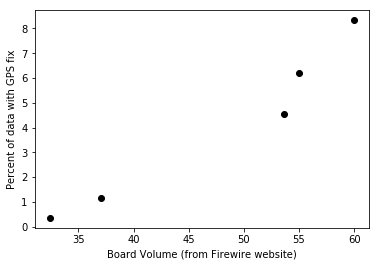

In [30]:
fig, axs = plt.subplots()
axs.plot(percent_gps_fix.volume, percent_gps_fix.unique_lat, 'ko')
# axs.errorbar(percent_gps_fix.volume, percent_gps_fix.unique_lat, 
#              percent_gps_fix.CoV, fmt='o')
axs.set_xlabel('Board Volume (from Firewire website)')
axs.set_ylabel('Percent of data with GPS fix')

In [23]:
8.32/.352

23.63636363636364